Name: Karthik Venugopal

USC ID: 9330529336

github username: Karthikvenugopal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report

In [2]:
base_dir = "SeparatedWaste"
train_dir, val_dir, test_dir = [os.path.join(base_dir, subdir) for subdir in ("train", "val", "test")]

img_height, img_width = 224, 224
batch_size = 5
epochs = 100

preprocess_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

In [3]:
data_dirs = {'train': train_dir, 'val': val_dir, 'test': test_dir}
data_gens = {
    split: preprocess_gen.flow_from_directory(
        dir_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=(split == 'train')
    )
    for split, dir_path in data_dirs.items()
}

train_gen = data_gens['train']
val_gen = data_gens['val']
test_gen = data_gens['test']

Found 3323 images belonging to 9 classes.
Found 710 images belonging to 9 classes.
Found 719 images belonging to 9 classes.


In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
for units in [256, 128, 64]:
    x = Dense(units, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    if units == 128:
        x = Dropout(0.2)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


665/665 ━━━━━━━━━━━━━━━━━━━━ 332s 499ms/step - accuracy: 0.1560 - loss: 8.4335 - val_accuracy: 0.3380 - val_loss: 7.8054
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 359s 540ms/step - accuracy: 0.2996 - loss: 7.6515 - val_accuracy: 0.4296 - val_loss: 7.2494
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 376s 566ms/step - accuracy: 0.3712 - loss: 7.2165 - val_accuracy: 0.5437 - val_loss: 6.8124
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 386s 580ms/step - accuracy: 0.4543 - loss: 6.9310 - val_accuracy: 0.5718 - val_loss: 6.5144
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 396s 596ms/step - accuracy: 0.4732 - loss: 6.6631 - val_accuracy: 0.5972 - val_loss: 6.2884
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 418s 628ms/step - accuracy: 0.5284 - loss: 6.4023 - val_accuracy: 0.6042 - val_loss: 6.0375
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 411s 618ms/step - accuracy: 0.5194 - loss: 6.2110 - val_accuracy: 0.6239 - val_loss: 5.8221
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 399s 600ms/step - accuracy: 0.5498 - los

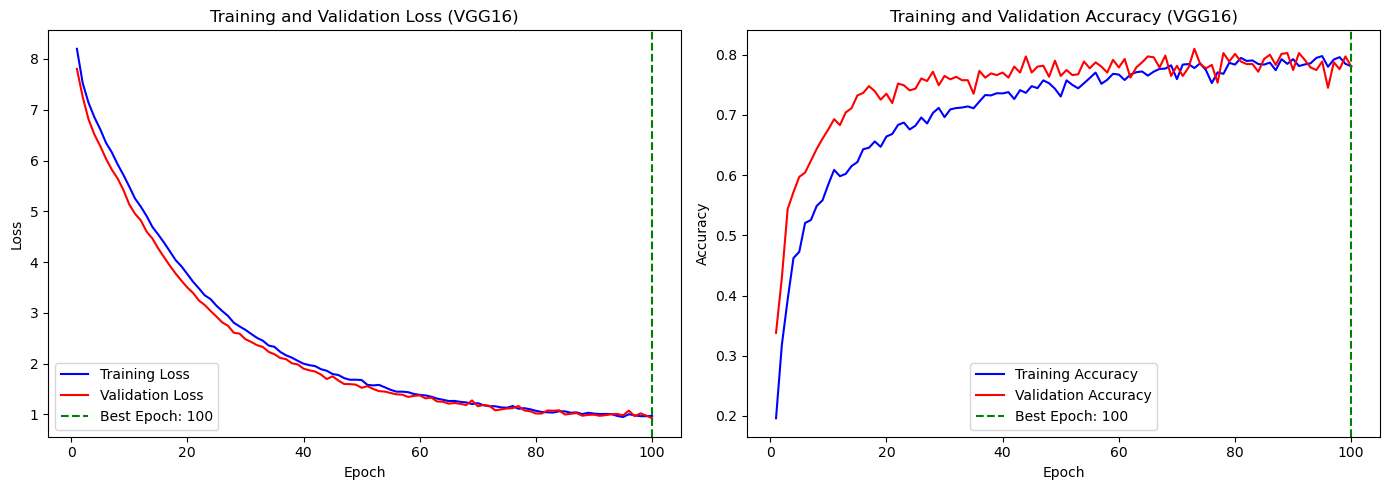

In [6]:
history_df = pd.DataFrame(history.history)
best_epoch = history_df['val_loss'].idxmin() + 1
epoch_range = np.arange(1, len(history_df) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epoch_range, history_df['loss'], 'b', label='Training Loss')
axes[0].plot(epoch_range, history_df['val_loss'], 'r', label='Validation Loss')
axes[0].axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch: {best_epoch}')
axes[0].set_title('Training and Validation Loss (VGG16)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epoch_range, history_df['accuracy'], 'b', label='Training Accuracy')
axes[1].plot(epoch_range, history_df['val_accuracy'], 'r', label='Validation Accuracy')
axes[1].axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch: {best_epoch}')
axes[1].set_title('Training and Validation Accuracy (VGG16)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [7]:
y_test_probs = model.predict(test_gen, verbose=0)
y_test_preds = np.argmax(y_test_probs, axis=1)
y_test_true = test_gen.classes
class_names = [f"{i+1}-{name}" for i, name in enumerate(test_gen.class_indices)]

report_dict = classification_report(
    y_test_true, y_test_preds, target_names=class_names, output_dict=True
)
report_df = pd.DataFrame(report_dict).T.round(2)

summary = ['accuracy', 'macro avg', 'weighted avg']
ordered_rows = [row for row in report_df.index if row not in summary] + summary
report_df = report_df.loc[ordered_rows]

print("\n Classification Report for VGG16 on Test Set:\n")
print(report_df.to_string())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



 Classification Report for VGG16 on Test Set:

                         precision  recall  f1-score  support
1-1-Cardboard                 0.76    0.76      0.76    70.00
2-2-Food Organics             0.88    0.78      0.82    63.00
3-3-Glass                     0.71    0.71      0.71    63.00
4-4-Metal                     0.76    0.81      0.78   119.00
5-5-Miscellaneous Trash       0.61    0.59      0.60    75.00
6-6-Paper                     0.76    0.87      0.81    75.00
7-7-Plastic                   0.76    0.74      0.75   139.00
8-8-Textile Trash             0.84    0.55      0.67    49.00
9-9-Vegetation                0.80    0.95      0.87    66.00
accuracy                      0.76    0.76      0.76     0.76
macro avg                     0.76    0.75      0.75   719.00
weighted avg                  0.76    0.76      0.76   719.00
